# Practice5. Keras-RNN

In [1]:
import numpy as np
from keras.datasets import reuters

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess= tf.Session(config=config)

import sys
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8243701141038080675
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6177669120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11570989611797968138
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


## 1. reuters dataset 다운로드

In [3]:
max_features = 5000
# cut texts after this number of words (among top max_features most common words), 바꾸지 마세요!
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=max_features,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

## 2. Data shape 확인
- x_train, x_test의 형태를 꼭 확인할 것

In [4]:
print ('x_train.shape : ', x_train.shape,'\ty_train.shape : ',  y_train.shape)
print ('x_test.shape : ', x_test.shape,'\ty_test.shape : ',  y_test.shape)
print ()
print ('len(x_train[0]) : ', len(x_train[0]),'\tlen(x_test[0]) : ', len(x_test[0]))
print ('len(x_train[-1]) : ', len(x_train[-1]),'\tlen(x_test[-1]) : ', len(x_test[-1]))

x_train.shape :  (8982,) 	y_train.shape :  (8982,)
x_test.shape :  (2246,) 	y_test.shape :  (2246,)

len(x_train[0]) :  87 	len(x_test[0]) :  145
len(x_train[-1]) :  105 	len(x_test[-1]) :  272


### 3. a list of sequences를 2D Numpy array로 변환
- 참고 : https://keras.io/preprocessing/sequence/#pad_sequences

In [5]:
from keras.preprocessing import sequence

################################### 바꿔가면서 해보세요 ################################

max_sentence_length = 313

###################################################################################

x_train = sequence.pad_sequences(x_train, maxlen=max_sentence_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_sentence_length)

print ('max sentence length for embedding is %d' % (max_sentence_length))

max sentence length for embedding is 313


## 3. Classification을 위한 cetegorical label 생성

In [6]:
from keras.utils import np_utils

input_shape = x_train.shape[1:]
output_shape = np.max(y_train) + 1

print ("max_label : ", output_shape)

y_train_onehot=np_utils.to_categorical(y_train,output_shape)
y_test_onehot=np_utils.to_categorical(y_test,output_shape)

print ('x_train.shape \t: ' + str(x_train.shape))
print ('y_train_onehot.shape : ' + str(y_train_onehot.shape))
print ('x_test.shape \t: ' + str(x_test.shape))
print ('y_test_onehot.shape : ' + str(y_test_onehot.shape))

max_label :  46
x_train.shape 	: (8982, 313)
y_train_onehot.shape : (8982, 46)
x_test.shape 	: (2246, 313)
y_test_onehot.shape : (2246, 46)


## 4. Embedding vector length 설정
- Embedding layer : https://keras.io/layers/embeddings/

In [7]:
################################### 바꿔가면서 해보세요 ################################

embedding_vecor_length = 64

###################################################################################
print ('embedding vector size is %d'% (embedding_vecor_length))

embedding vector size is 64


## 5. Model 만들기
- Keras Documentation : https://keras.io
- Embedding layer : https://keras.io/layers/embeddings/
- Recurrent layer : https://keras.io/layers/recurrent/
- Convolution layer : https://keras.io/layers/convolutional/
- Drop out : https://keras.io/layers/core/#dropout
- Sequence classification with LSTM : https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-lstm
- Documentation 참고하면서 다양한 형태로 모델을 만들어보세요.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization

In [9]:

input_layer = Input(shape=input_shape)
layer = input_layer

################################### Documentation 참고해서 레이어를 바꿔보세요 ################################

layer = Embedding(max_features, embedding_vecor_length, embeddings_initializer='uniform')(layer)
layer = BatchNormalization()(layer)
layer = GRU(72, return_sequences=True)(layer)
layer = BatchNormalization()(layer)
layer = GRU(72)(layer)
layer = Dropout(0.3)(layer)

########################################################################################################

layer = Dense(output_shape, activation='softmax')(layer)

output_layer = layer
model = Model(inputs=[input_layer], outputs=[output_layer])

### Optimizer 설정, 모델 컴파일

In [10]:
from keras.optimizers import Adam, RMSprop
################################ 바꿔가면서 해보세요 ######################################
rmsprop = RMSprop()
######################################################################################
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

### Summary() 확인

In [11]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 313)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 313, 64)           320000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 313, 64)           256       
_________________________________________________________________
gru_1 (GRU)                  (None, 313, 72)           29592     
_________________________________________________________________
batch_normalization_2 (Batch (None, 313, 72)           288       
_________________________________________________________________
gru_2 (GRU)                  (None, 72)                31320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 72)                0         
__________

### 모델 visualization (선택)

In [12]:
import matplotlib.image as mpimg
from keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(model,'model_image.png', show_layer_names=False, show_shapes=True)
model_img=mpimg.imread('model_image.png')
plt.figure(figsize=[10,50])
plt.imshow(model_img)

## 5. Model 학습

In [13]:
################################ 바꿔가면서 해보세요 ######################################
num_epochs = 10
mini_batch_size = 48
######################################################################################
history = model.fit(x_train, y_train_onehot,validation_data=[x_test, y_test_onehot], epochs=num_epochs, batch_size=mini_batch_size, verbose=1)

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 336s 37ms/step - loss: 1.8026 - acc: 0.5665 - val_loss: 1.3066 - val_acc: 0.6959
Epoch 2/10
8982/8982 [==============================] - 300s 33ms/step - loss: 1.0713 - acc: 0.7537 - val_loss: 1.0228 - val_acc: 0.7685
Epoch 3/10
8982/8982 [==============================] - 335s 37ms/step - loss: 0.7887 - acc: 0.8233 - val_loss: 0.9058 - val_acc: 0.7885
Epoch 4/10
8982/8982 [==============================] - 311s 35ms/step - loss: 0.6121 - acc: 0.8647 - val_loss: 0.8978 - val_acc: 0.8068
Epoch 5/10
8982/8982 [==============================] - 262s 29ms/step - loss: 0.4919 - acc: 0.8897 - val_loss: 0.9080 - val_acc: 0.7952
Epoch 6/10
8982/8982 [==============================] - 193s 22ms/step - loss: 0.3968 - acc: 0.9097 - val_loss: 0.9388 - val_acc: 0.7894
Epoch 7/10
8982/8982 [==============================] - 193s 21ms/step - loss: 0.3386 - acc: 0.9230 - val_loss: 0.9588 - val_acc: 

## 6. Visualization

## Mission :  Test Accuray 75% 이상 달성하기
- 바꿀 수 있는 것 : max_sentence_length, embedding_vecor_length, num_epochs, mini_batch_size, Optimizer, 모델 구조
- 위 요소들을 바꿔보면서 각각의 요소와 최종 결과의 관계를 한번 파악해보세요. (Overfitting vs Underfitting)
- 달성한 Accuracy가 보이게 6. Visualization 까지 실행된 코드를 제출해주세요.

<Figure size 432x288 with 0 Axes>

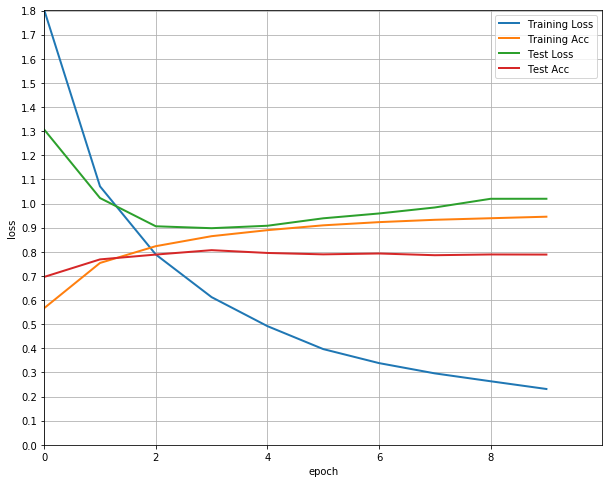

Best accuray :  0.8068


In [14]:
#plot training graph
plt.clf()
plt.figure(figsize=(10,8))
plt.grid(True)
plt.yticks(np.arange(0, max(max(history.history['loss']),max(history.history['val_loss'])), 0.1))
plt.xticks(np.arange(0, num_epochs, 2))
plt.ylim([0.0, max(max(history.history['loss']), max(history.history['val_loss']))])
plt.xlim([0, num_epochs])

plt.plot(history.history['loss'][:], lw=2, label='Training Loss')
plt.plot(history.history['acc'][:], lw=2, label='Training Acc')
plt.plot(history.history['val_loss'][:], lw=2, label='Test Loss')
plt.plot(history.history['val_acc'][:], lw=2, label='Test Acc')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Training Acc', 'Test Loss','Test Acc'], loc='upper right')
plt.show()

print ('Best accuray : ', round(np.max(np.array(history.history['val_acc'])),4))